In [2]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19 LTS; OpenJDK Runtime Environment Zulu11.56+19-CA (build 11.0.15+10-LTS); OpenJDK 64-Bit Server VM Zulu11.56+19-CA (build 11.0.15+10-LTS, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/6s/z3758tx16yd17yy35vnsnx_80000gn/T/tmpg62lteqe
  JVM stdout: /var/folders/6s/z3758tx16yd17yy35vnsnx_80000gn/T/tmpg62lteqe/h2o_davidnunez_started_from_python.out
  JVM stderr: /var/folders/6s/z3758tx16yd17yy35vnsnx_80000gn/T/tmpg62lteqe/h2o_davidnunez_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Asuncion
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,2 months and 3 days
H2O_cluster_name:,H2O_from_python_davidnunez_nv1rbb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [3]:
import pandas as pd
df = pd.read_csv('../df_dummizado.csv', index_col=False)
df.drop('Protestas', axis=1, inplace=True)

df_complaints = df[(df['has_complaint'] == True)]
df_no_complaints = df[(df['has_complaint'] == False)]

n_cmp = len(df_complaints.index)
n_no_cmp = len(df_no_complaints.index)
df_no_complaints = df_no_complaints.sample(int(n_cmp*3/2)) #Sample 60% no complaints 40 % complaints
balanced_df = pd.concat([df_complaints, df_no_complaints])

In [8]:
balanced_df.shape

(25830, 869)

In [4]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(balanced_df, test_size=0.2, random_state=42)
train = h2o.H2OFrame.from_python(train_data)
test = h2o.H2OFrame.from_python(test_data)
# Identify predictors and response
y = "has_complaint"
x = train.columns
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leader
# board
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |
14:26:24.943: AutoML: XGBoost is not available; skipping it.
14:26:24.969: _train param, Dropping bad and constant columns: [parties.details.legalEntityTypeDetail payer_3, parties.details.legalEntityTypeDetail payer_23, parties.details.legalEntityTypeDetail payer_4, parties.details.legalEntityTypeDetail payer_1, parties.details.legalEntityTypeDetail payer_21, parties.details.legalEntityTypeDetail payer_2, parties.details.legalEntityTypeDetail payer_22, parties.details.legalEntityTypeDetail payer_7, parties.details.legalEntityTypeDetail payer_8, parties.details.legalEntityTypeDetail payer_5, parties.details.legalEntityTypeDetail payer_6, awards.documents.DocumentTypeDetails_17, parties.details.legalEntityTypeDetail tenderer_18, parties.details.legalEntityTypeDetail payer_20, contracts.investmentProjects.id_34, parties.details.legalEntityTypeDetail enquirer_14, parties.details.legalEntityTypeDetail enquirer_15, parties.details.legalEntityTypeDetail buyer_15, parties.de

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20230701_142624,0.943889,0.292778,0.924315,0.129173,0.301345,0.0908087
StackedEnsemble_BestOfFamily_1_AutoML_1_20230701_142624,0.941707,0.297083,0.922277,0.132759,0.304246,0.0925659
GBM_grid_1_AutoML_1_20230701_142624_model_5,0.941332,0.301924,0.921305,0.133227,0.30562,0.0934035
GBM_grid_1_AutoML_1_20230701_142624_model_4,0.940257,0.302379,0.918644,0.134082,0.306641,0.0940286
GBM_grid_1_AutoML_1_20230701_142624_model_1,0.940179,0.303442,0.918559,0.133562,0.306453,0.0939137
GBM_4_AutoML_1_20230701_142624,0.939437,0.304184,0.917917,0.134265,0.307712,0.0946865
GBM_3_AutoML_1_20230701_142624,0.93651,0.312192,0.912698,0.14081,0.312394,0.0975902
GBM_1_AutoML_1_20230701_142624,0.935863,0.313375,0.911414,0.139254,0.313362,0.0981958
GBM_2_AutoML_1_20230701_142624,0.934777,0.316347,0.910222,0.141727,0.314747,0.0990654
GBM_5_AutoML_1_20230701_142624,0.930035,0.327649,0.904472,0.149385,0.321031,0.103061


In [6]:
preds = aml.predict(test)


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20230701_142624,0.945535,0.291065,0.928125,0.131806,0.301521,0.0909149,7547,0.043836,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20230701_142624,0.944703,0.291509,0.92875,0.130078,0.301629,0.0909798,3952,0.019102,StackedEnsemble
GBM_grid_1_AutoML_1_20230701_142624_model_5,0.944453,0.294043,0.927132,0.128957,0.302192,0.0913198,16766,0.013669,GBM
GBM_4_AutoML_1_20230701_142624,0.941043,0.303088,0.920984,0.131544,0.307402,0.0944963,11802,0.016907,GBM
GBM_grid_1_AutoML_1_20230701_142624_model_1,0.940714,0.304284,0.921539,0.136118,0.308714,0.0953042,9186,0.013643,GBM
GBM_grid_1_AutoML_1_20230701_142624_model_4,0.939866,0.304834,0.919287,0.135369,0.308712,0.0953028,10449,0.015644,GBM
GBM_1_AutoML_1_20230701_142624,0.934747,0.317946,0.910784,0.141381,0.316264,0.100023,13675,0.01475,GBM
GBM_3_AutoML_1_20230701_142624,0.934372,0.3183,0.913413,0.141668,0.316291,0.10004,9738,0.012829,GBM
GBM_2_AutoML_1_20230701_142624,0.933911,0.320799,0.913122,0.146746,0.318298,0.101314,9385,0.015877,GBM
DRF_1_AutoML_1_20230701_142624,0.929869,0.331989,0.913225,0.151487,0.324279,0.105157,7496,0.009263,DRF


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_1_AutoML_1_20230701_142624

,False,True,Error,Rate
False,2726.0,337.0,0.11,(337.0/3063.0)
True,323.0,1780.0,0.1536,(323.0/2103.0)
Total,3049.0,2117.0,0.1278,(660.0/5166.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

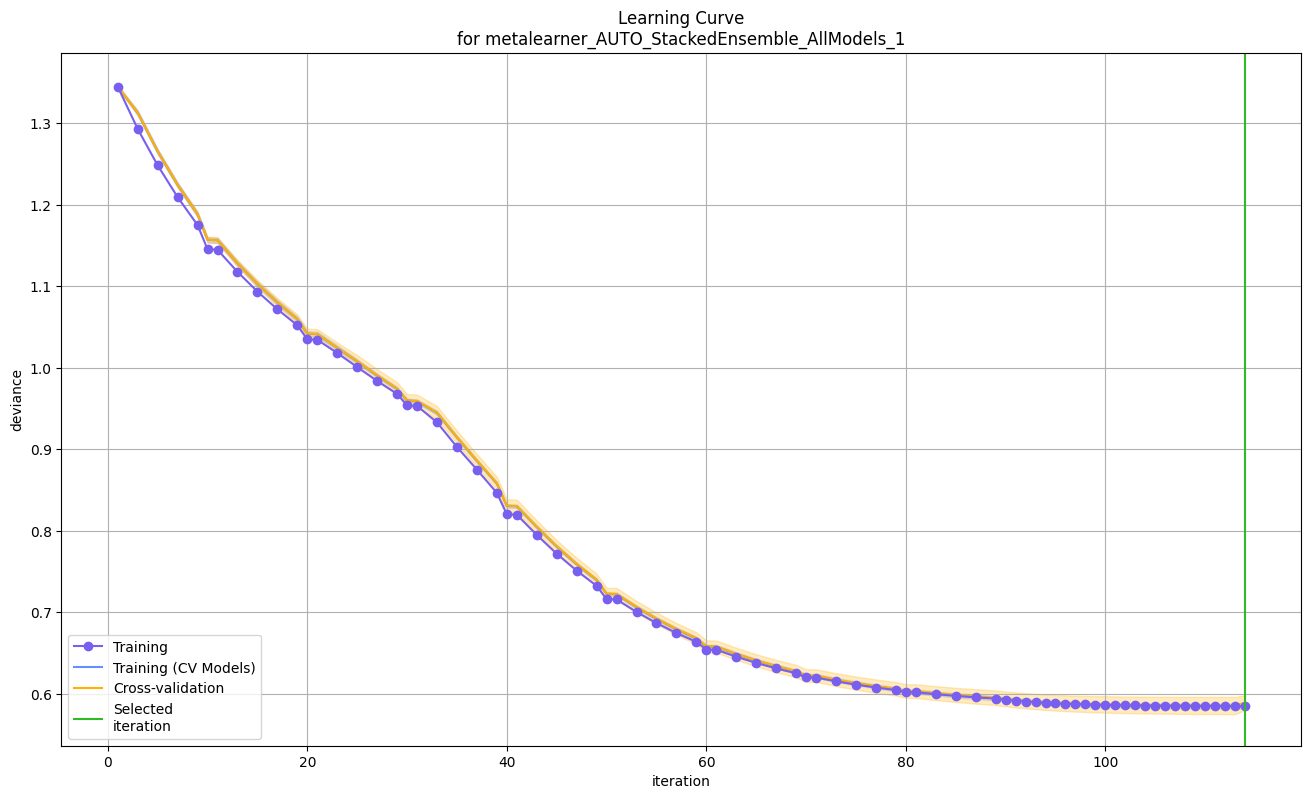

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

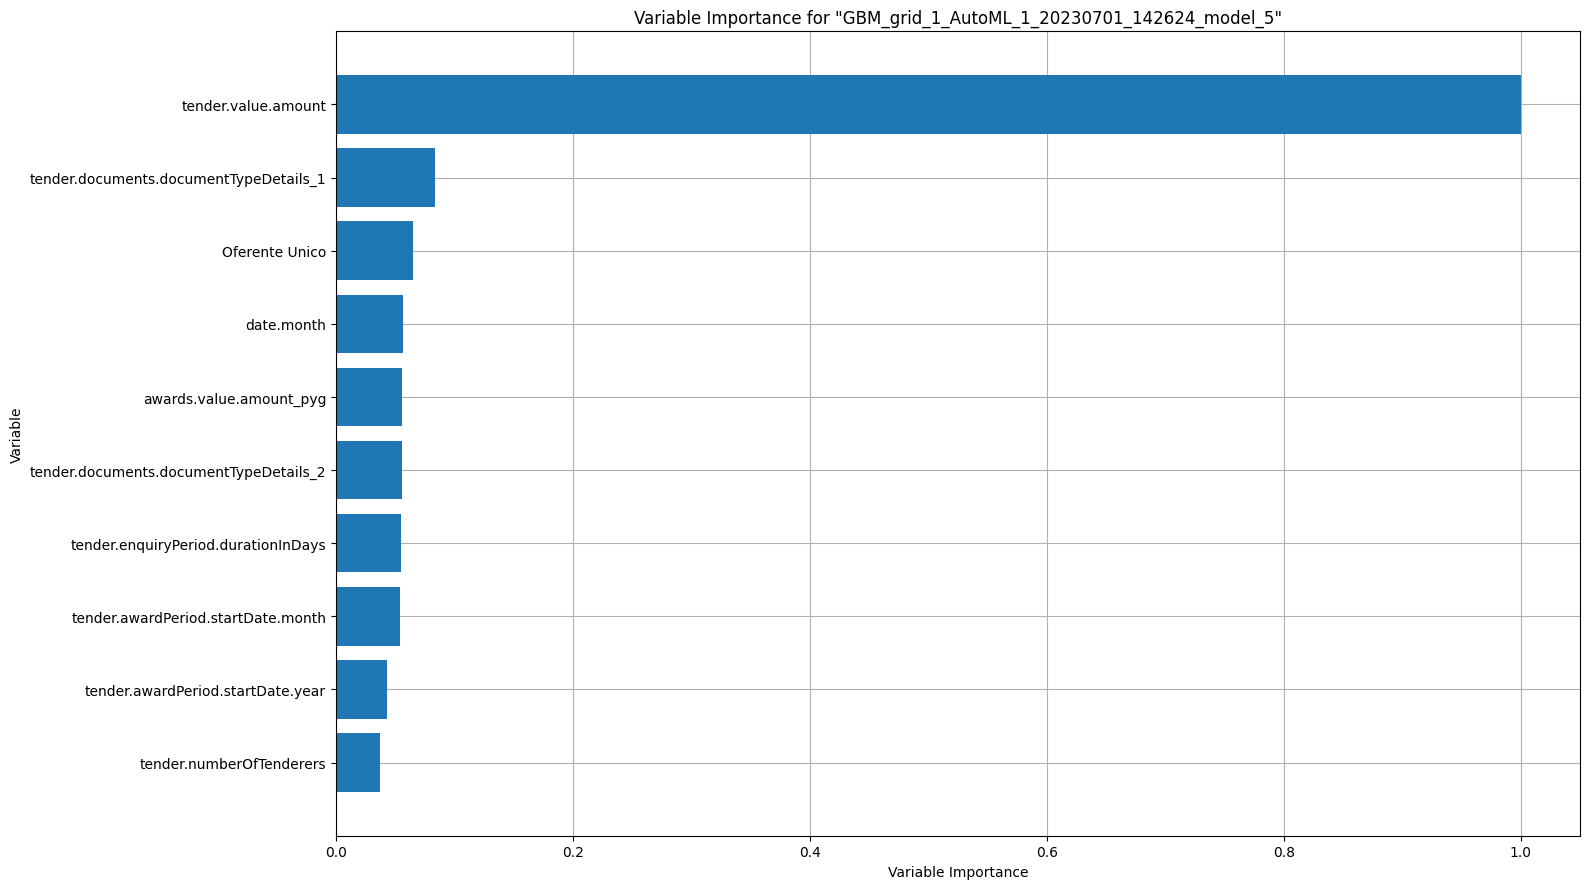

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

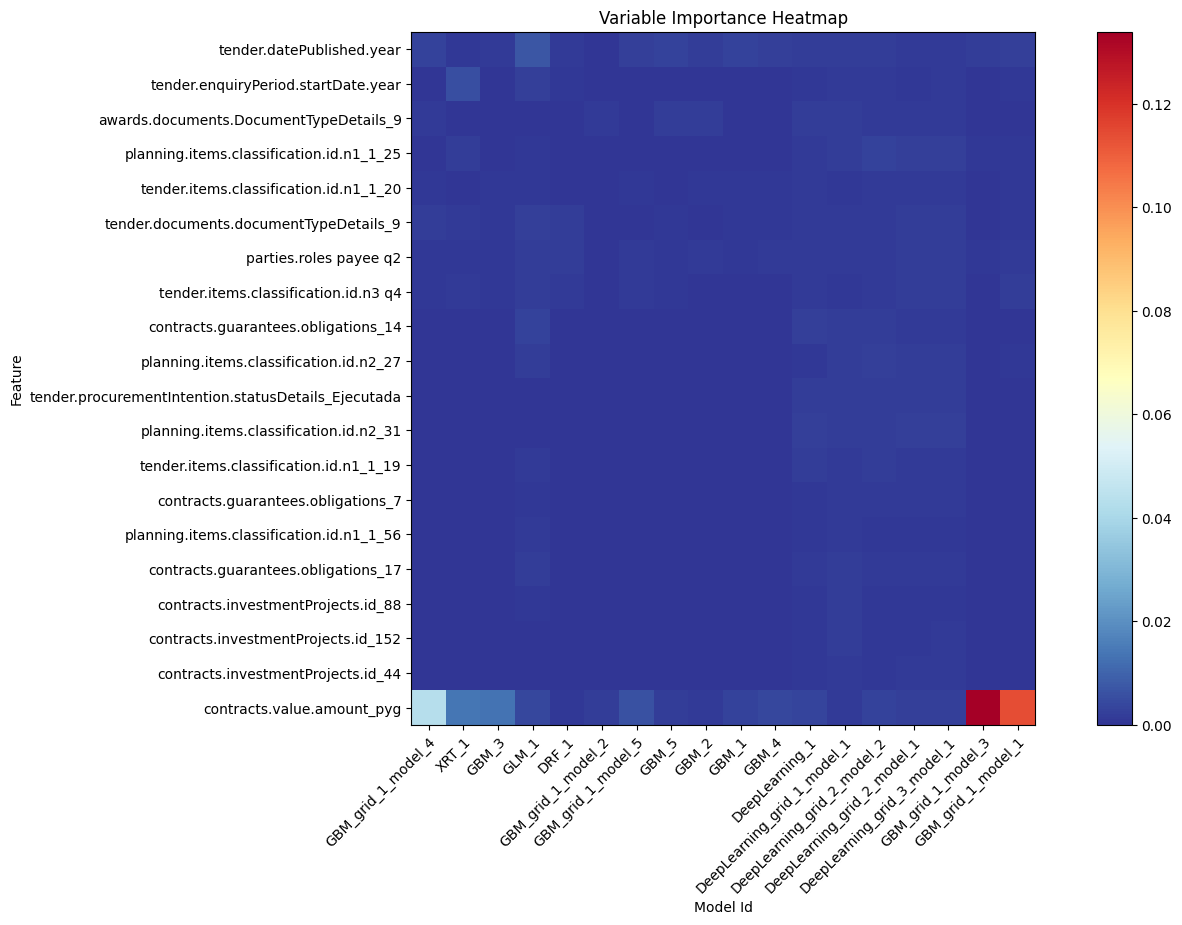

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

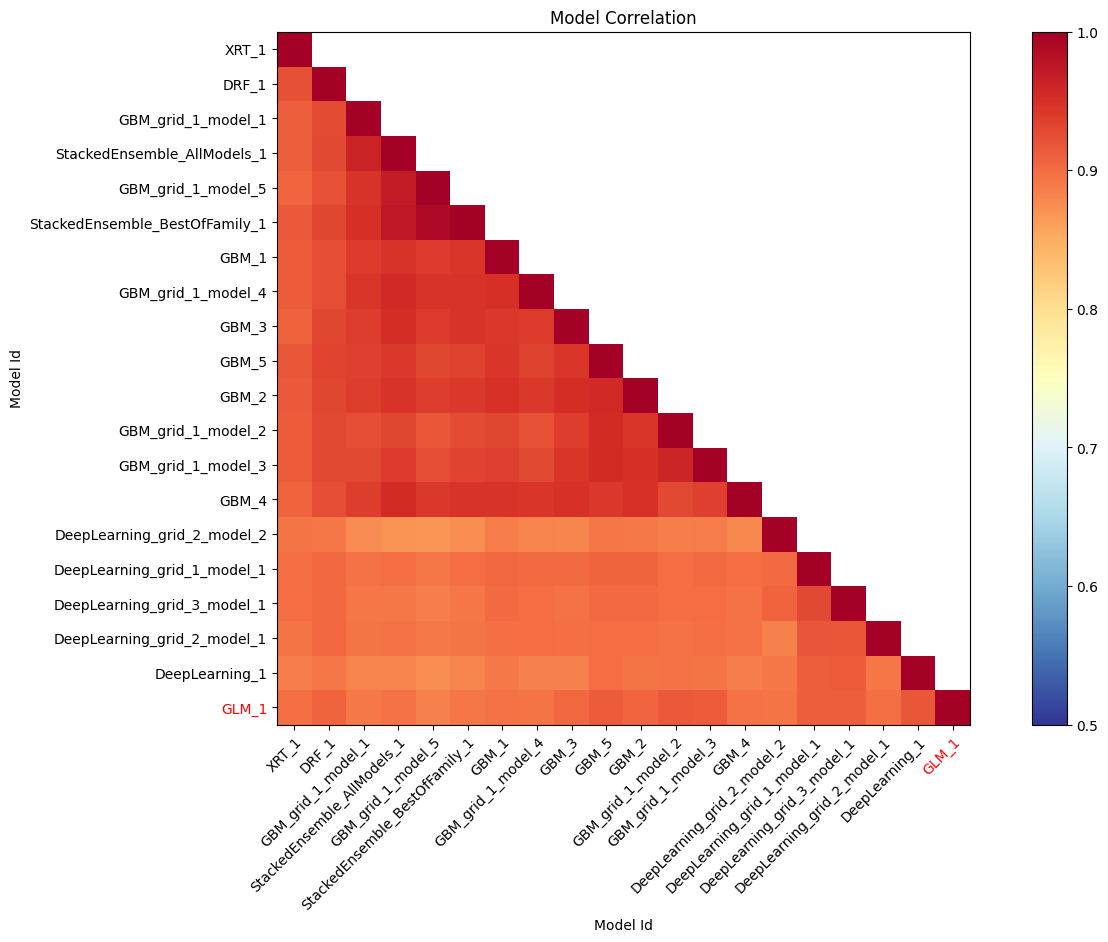

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

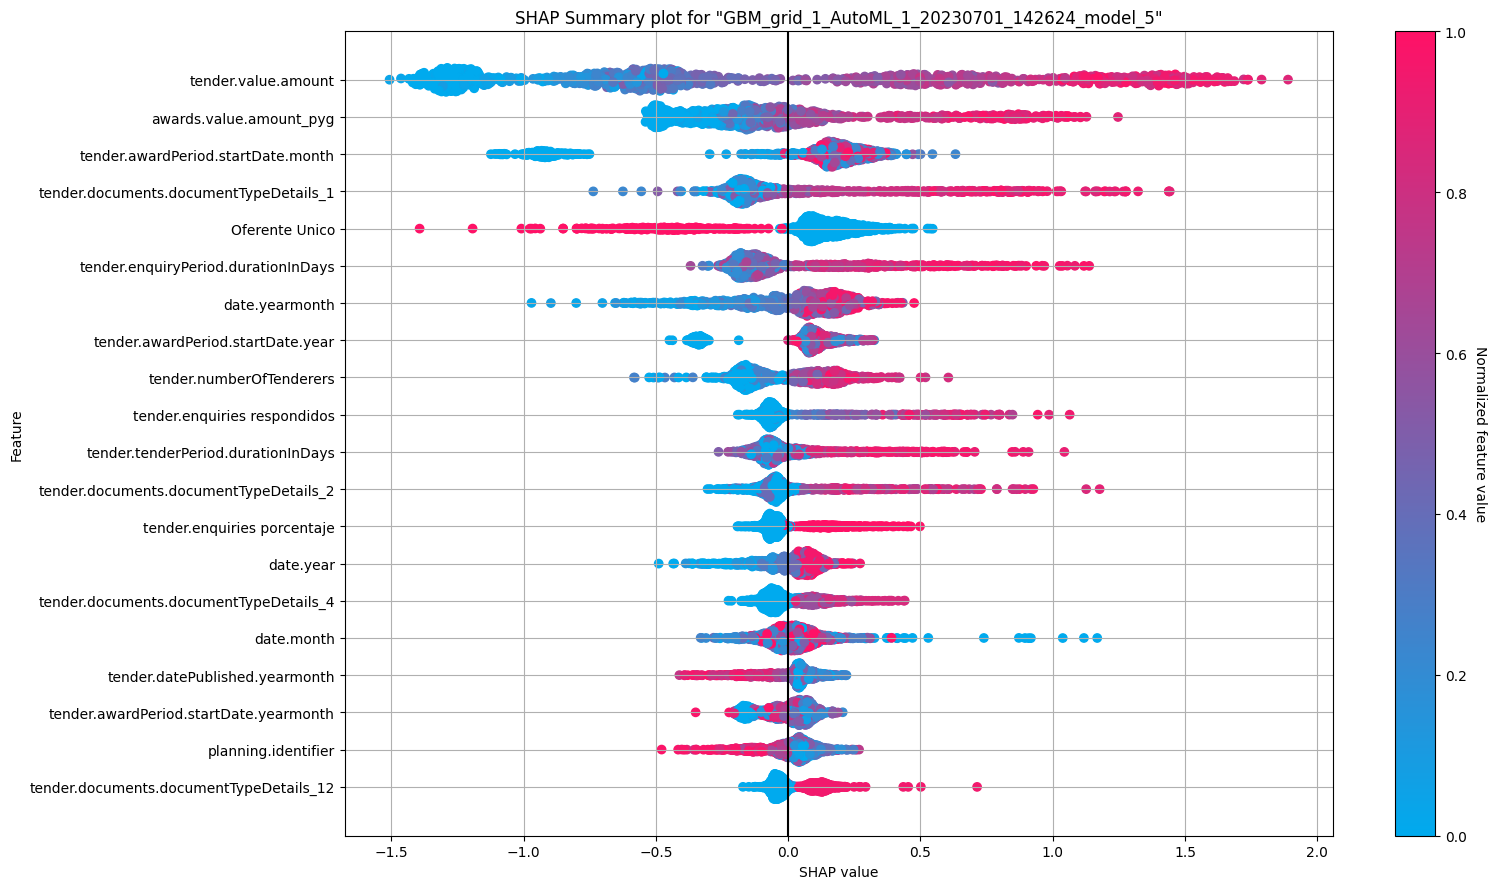

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

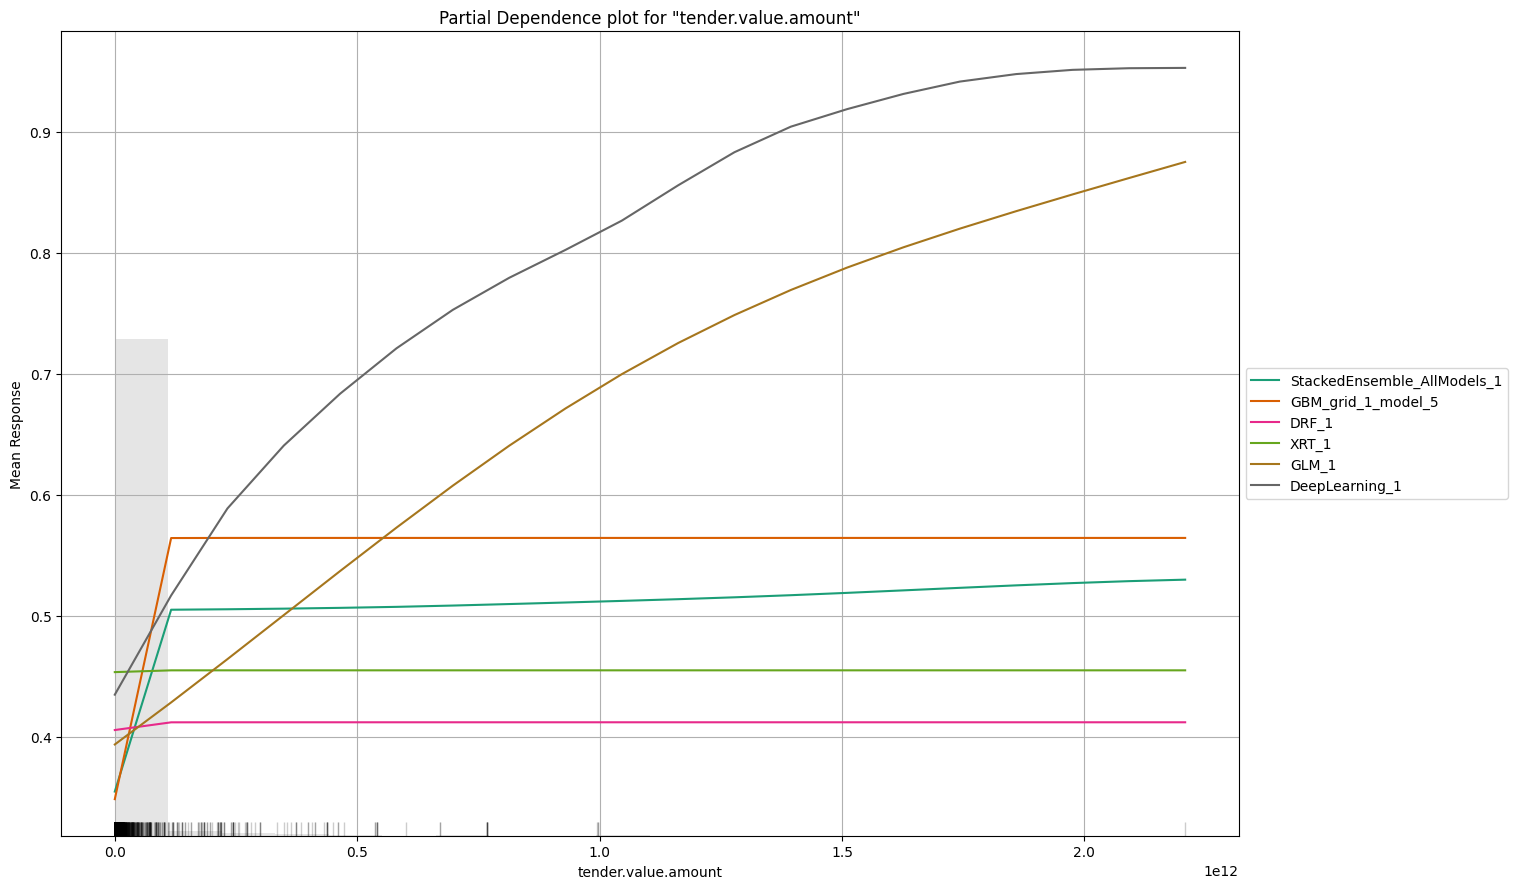

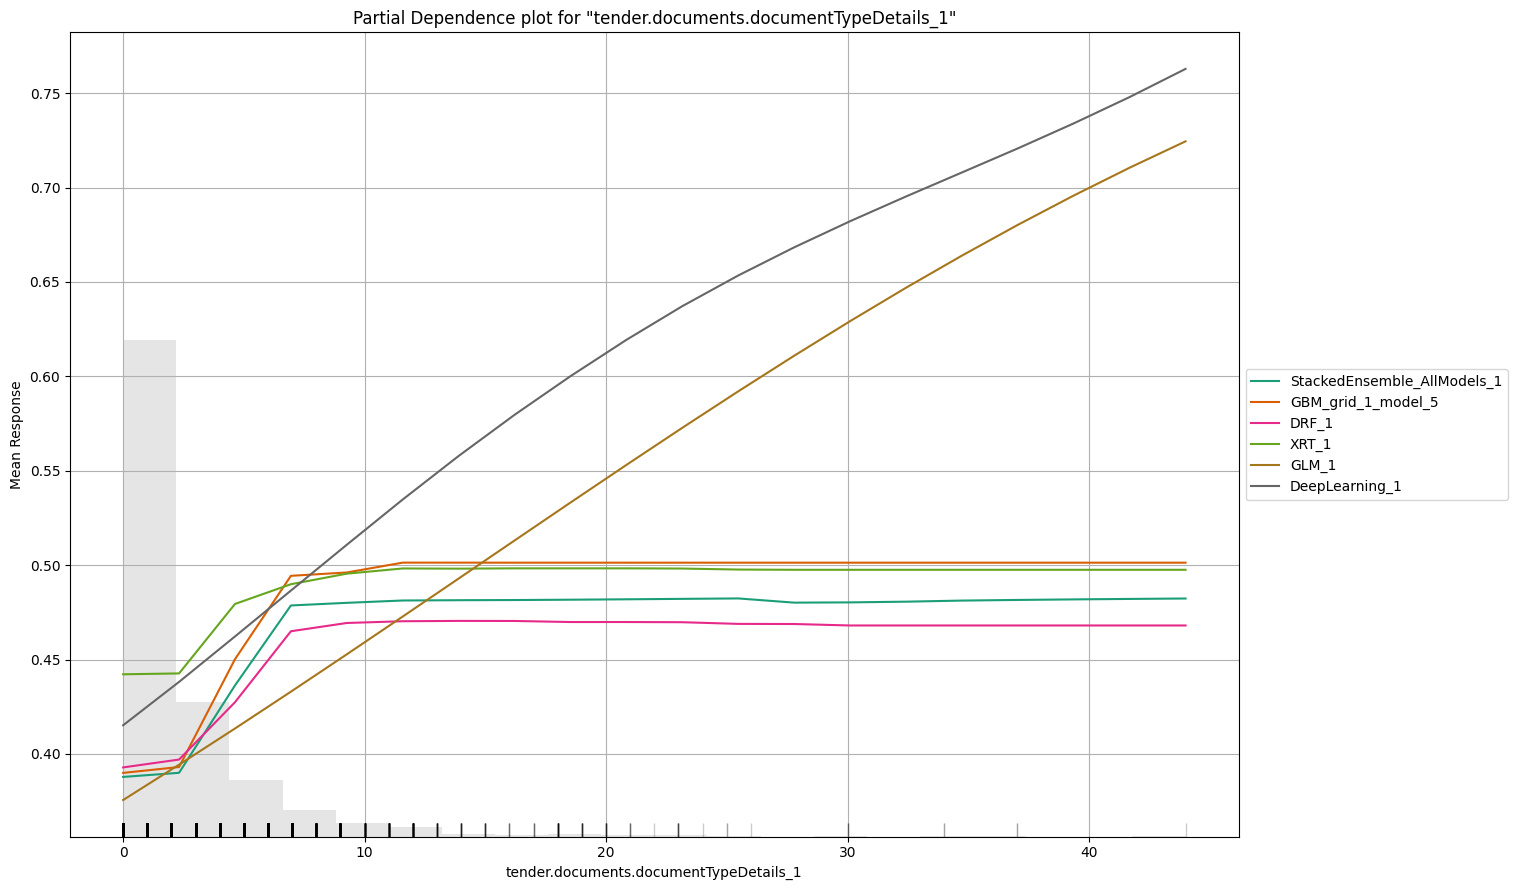

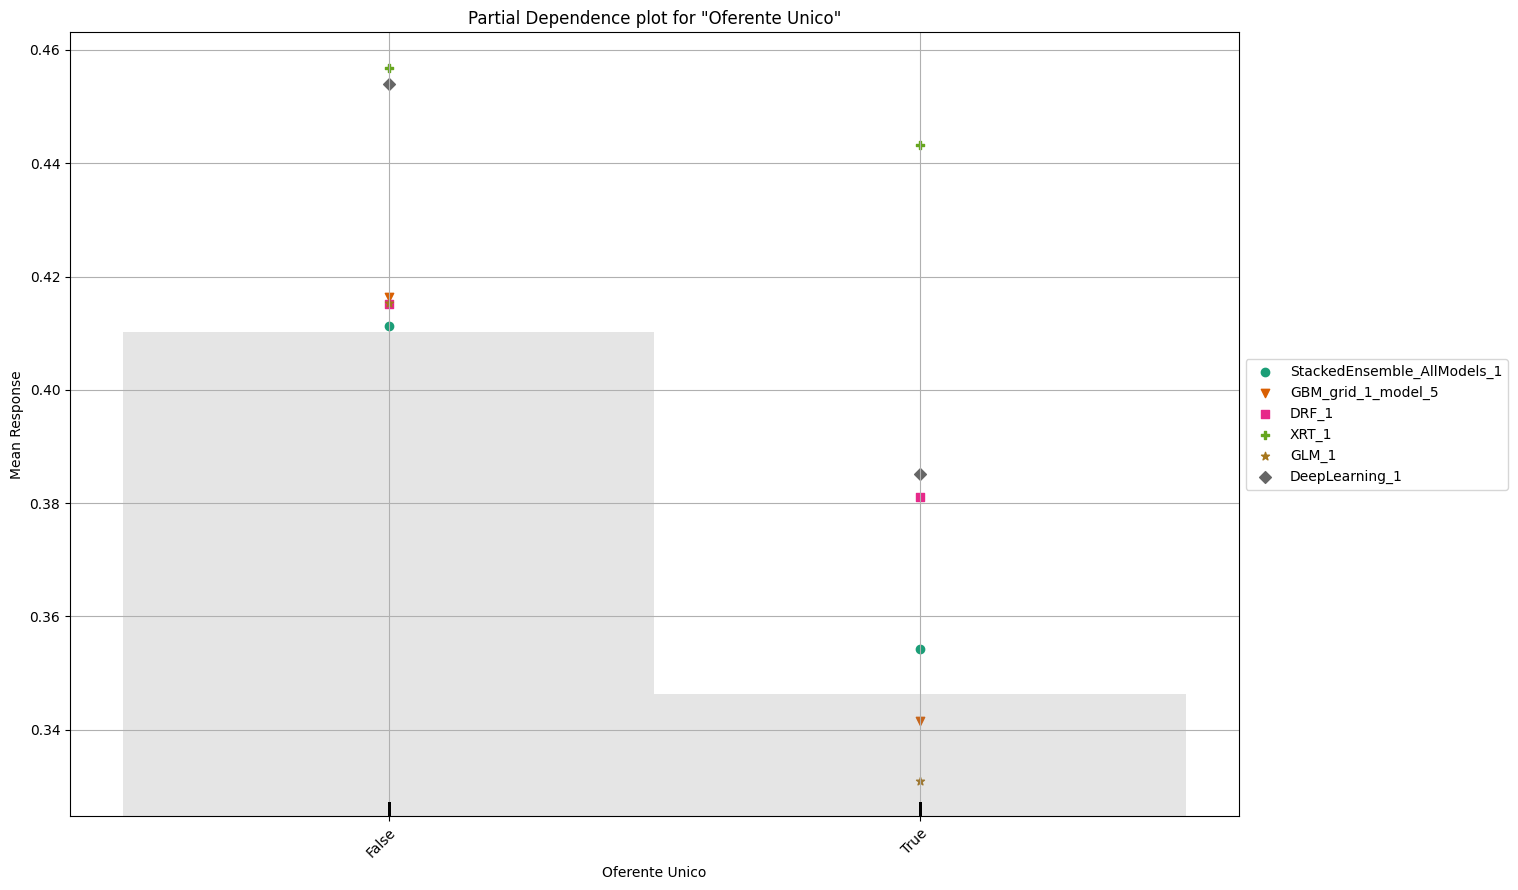

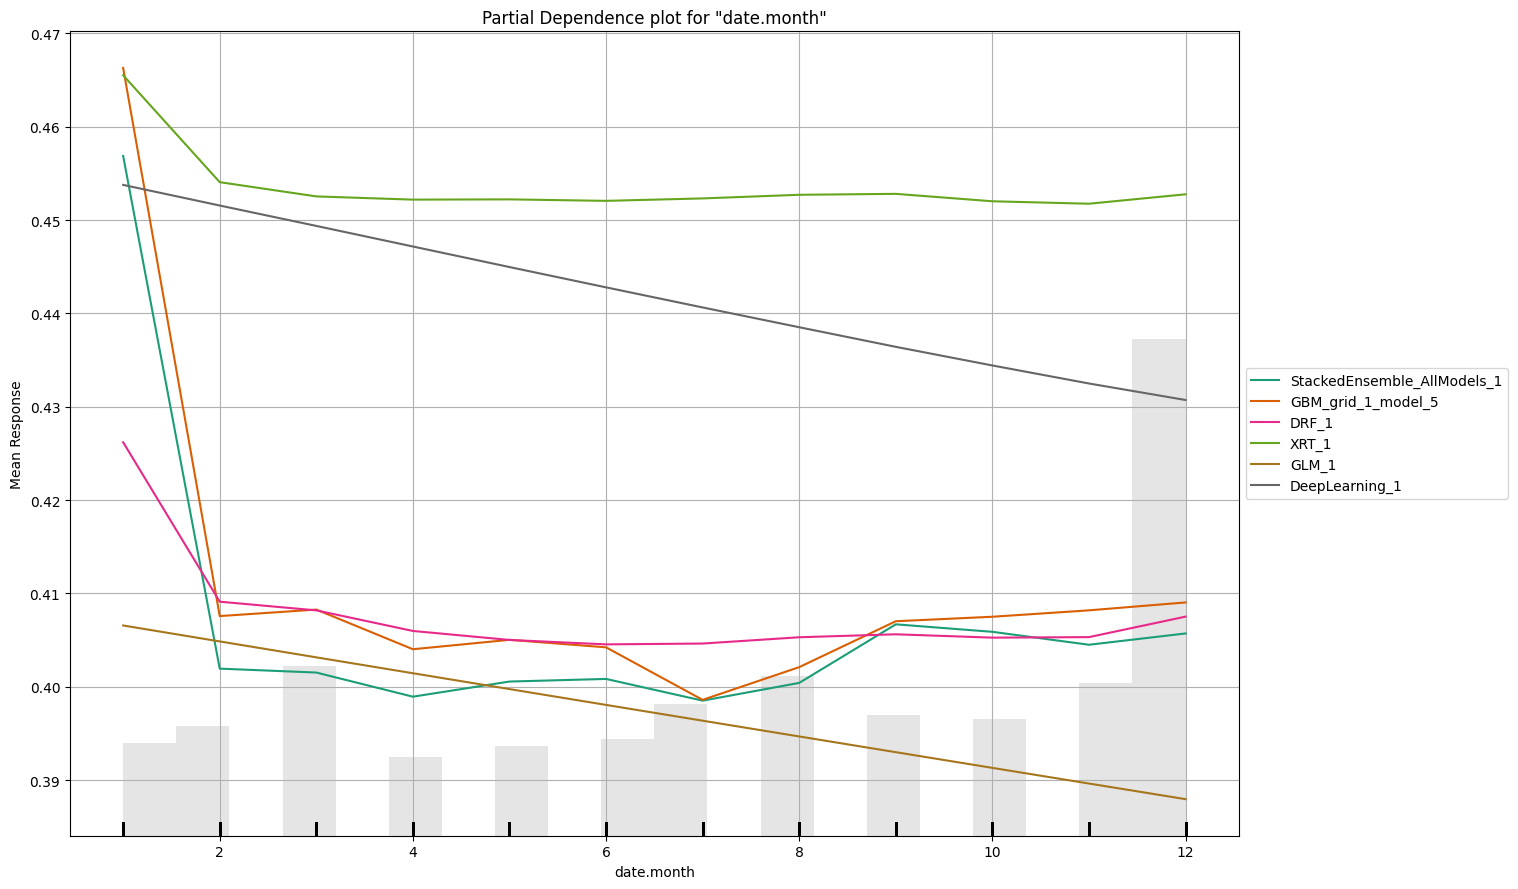

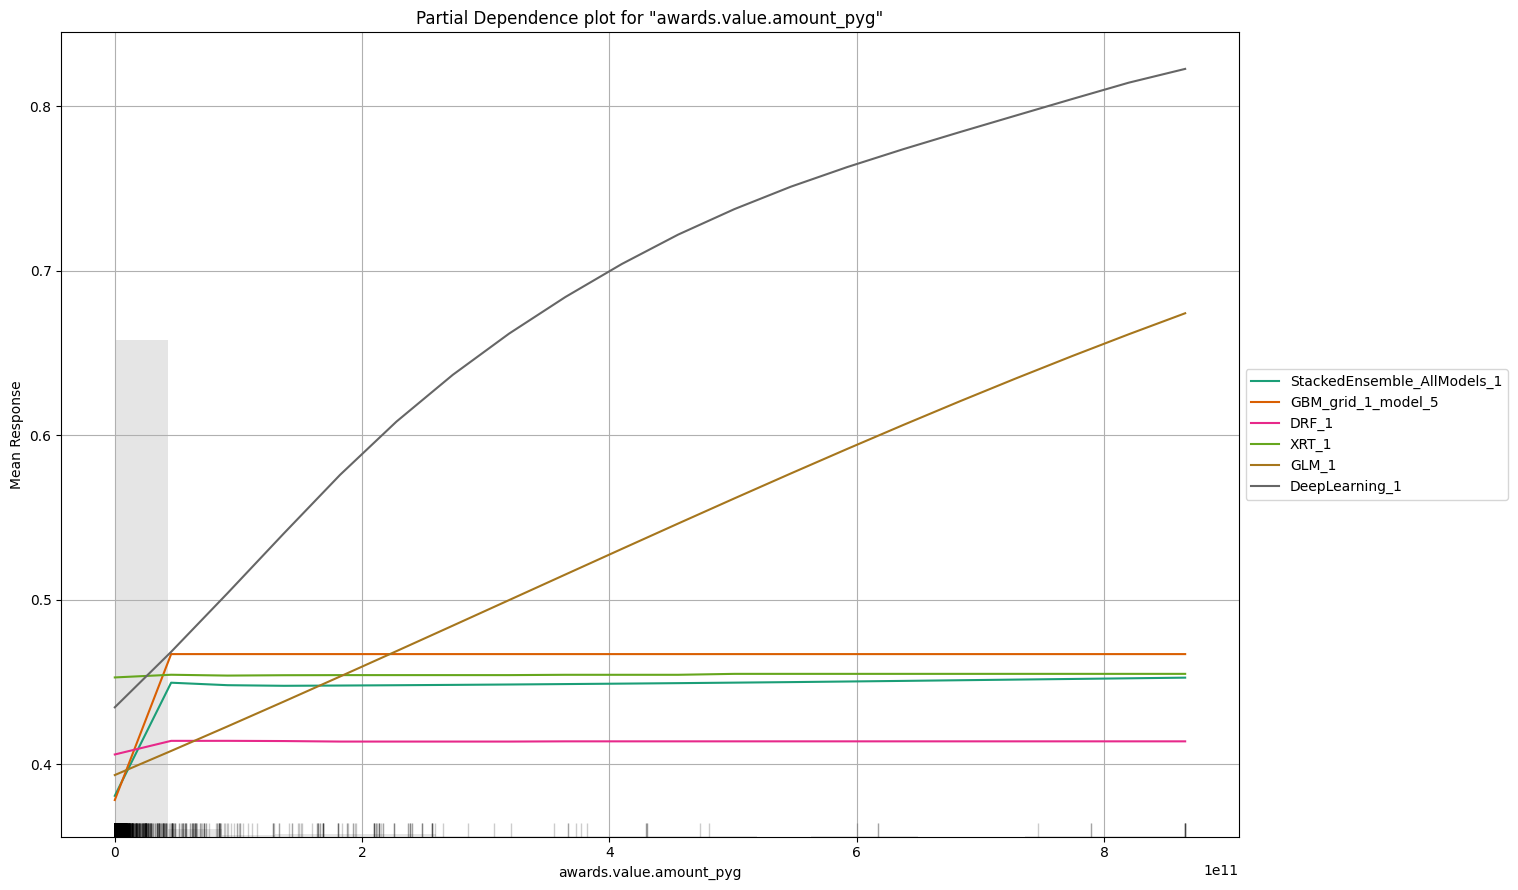

In [7]:
exa = aml.explain(test)
